<a href="https://colab.research.google.com/github/aman5319/Simple-SSD-Pytorch/blob/master/SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SSD300

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Import statements

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches,patheffects

import torch
from torchvision import datasets,transforms,models
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import torchvision.transforms.functional as FT

from PIL import Image
import xml.etree.ElementTree as ET


from pathlib import Path
import json
import os
import random
from tqdm import tqdm,trange
import time
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"{torch.__version__} and {device}")

1.0.1.post2 and cuda


## Download the PASCAl VOC 2007 Dataset

In [0]:
!wget -q http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar
dataPath=Path("VOCdevkit/VOC2007/")

## Transformations

### Horizontal Flip

In [0]:
def flip(image, boxes):
    """
    Flip image horizontally.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

### Resize

In [0]:
def resize(image, boxes, dims=(300, 300), return_percent_coords=True):
  """
  Resize image. For the SSD300, resize to (300, 300).

  Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
  you may choose to retain them.

  :param image: image, a PIL Image
  :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
  :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
  """
  # Resize image
  new_image = FT.resize(image, dims)

  # Resize bounding boxes
  old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
  new_boxes = boxes / old_dims  # percent coordinates

  if not return_percent_coords:
      new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
      new_boxes = new_boxes * new_dims

  return new_image, new_boxes


### Photometric Distortion

In [0]:
def photometric_distort(image):
  """
  Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.

  :param image: image, a PIL Image
  :return: distorted image
  """
  new_image = image

  distortions = [FT.adjust_brightness,
                 FT.adjust_contrast,
                 FT.adjust_saturation,
                 FT.adjust_hue]

  random.shuffle(distortions)

  for d in distortions:
      if random.random() < 0.5:
          if d.__name__ is 'adjust_hue':
              # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
              adjust_factor = random.uniform(-18 / 255., 18 / 255.)
          else:
              # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
              adjust_factor = random.uniform(0.5, 1.5)

          # Apply this distortion
          new_image = d(new_image, adjust_factor)

  return new_image

## Dataset

In [0]:
class VOCDataset(Dataset):
  class_names = ('__background__',
                 'aeroplane', 'bicycle', 'bird', 'boat',
                 'bottle', 'bus', 'car', 'cat', 'chair',
                 'cow', 'diningtable', 'dog', 'horse',
                 'motorbike', 'person', 'pottedplant',
                 'sheep', 'sofa', 'train', 'tvmonitor')

  def __init__(self, data_dir, split):
      """Dataset for VOC data.
      Args:
          data_dir: the root of the VOC2007 or VOC2012 dataset, the directory contains the following sub-directories:
              Annotations, ImageSets, JPEGImages, SegmentationClass, SegmentationObject.
      """
      self.data_dir = data_dir
      self.split = split
      image_sets_file = self.data_dir/f"ImageSets/Main/{self.split}.txt"
      self.ids = VOCDataset._read_image_ids(image_sets_file)

      self.class_dict = {class_name: i for i, class_name in enumerate(self.class_names)}

  def __getitem__(self, index):
      image_id = self.ids[index]
      boxes, labels = self._get_annotation(image_id)
      image = self._read_image(image_id)
      image, boxes, labels = self.transform(image, boxes, labels , self.split)
      return image, boxes, labels

  def get_image(self, index):
      image_id = self.ids[index]
      image = self._read_image(image_id)
      return image

  def get_annotation(self, index):
      image_id = self.ids[index]
      return self._get_annotation(image_id)

  def __len__(self):
      return len(self.ids)

  @staticmethod
  def _read_image_ids(image_sets_file):
      ids = []
      with open(image_sets_file) as f:
          for line in f:
              ids.append(line.rstrip())
      return ids

  def _get_annotation(self, image_id):
      annotation_file = self.data_dir/f"Annotations/{image_id}.xml"
      objects = ET.parse(annotation_file).findall("object")
      boxes = []
      labels = []
      for obj in objects:
          class_name = obj.find('name').text.lower().strip()
          bbox = obj.find('bndbox')
          # VOC dataset format follows Matlab, in which indexes start from 0
          x1 = float(bbox.find('xmin').text) - 1
          y1 = float(bbox.find('ymin').text) - 1
          x2 = float(bbox.find('xmax').text) - 1
          y2 = float(bbox.find('ymax').text) - 1
          boxes.append([x1, y1, x2, y2])
          labels.append(self.class_dict[class_name])

      return (np.array(boxes, dtype=np.float32),
              np.array(labels, dtype=np.int64))

  def _read_image(self, image_id):
      image_file = self.data_dir/f"JPEGImages/{image_id}.jpg"
      image = Image.open(image_file).convert("RGB")
      return image

  def transform(self , image, boxes, labels , split):
    """
    Apply the transformations above.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :return: transformed image, transformed bounding box coordinates, transformed labels
    """
    assert split in {'train', 'test' , "val"}

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html
    self.mean = torch.tensor([0.485, 0.456, 0.406])
    self.std = torch.tensor([0.229, 0.224, 0.225])

    new_image = image
    new_boxes = torch.from_numpy(boxes)
    new_labels = torch.from_numpy(labels)
    # Skip the following operations if validation/evaluation
    if split == 'train':
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        new_image = photometric_distort(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (300, 300) - this also converts point coordinates to fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=self.mean.numpy(), std=self.std.numpy())

    return new_image, new_boxes, new_labels

  def denormalize(self , image):
    image = image.clone().detach().to("cpu")
    if len(image.shape)==4 : image = image.squeeze(0)
    image = image.permute(1,2,0) 
    image = image.mul_(self.std).add_(self.mean) #denormalize
    image = torch.clamp(image,0,1)
    return image.numpy()

In [8]:

trainset  = VOCDataset(dataPath,split="train")
valset = VOCDataset(dataPath,split="val")
print(len(trainset),len(valset))

2501 2510




## Visualization of Augmentation and Original

In [0]:
def show_img(im, ax=None):
    ax.imshow(im)
    ax.grid()
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 3)

def draw_im(dataset , index):
    f, (ax, ax1) = plt.subplots(1, 2,figsize=(15,10))   
    ax.set_title("Augmented")
    ax1.set_title("original")

    image , boxes , labels = dataset[index]
    image=dataset.denormalize(image)
    ax = show_img(image,ax)
    for box ,label in zip(boxes , labels):
        box = box * torch.FloatTensor([300]*4)
        draw_rect(ax,box )
        draw_text(ax, box[:2], dataset.class_names[label], sz=16)
    
    original = dataset.get_image(index)
    boxes , labels = dataset.get_annotation(index)
    ax1 = show_img(original,ax1)
    for box ,label in zip(boxes , labels):
      draw_rect(ax1,box )
      draw_text(ax1, box[:2], dataset.class_names[label], sz=16)

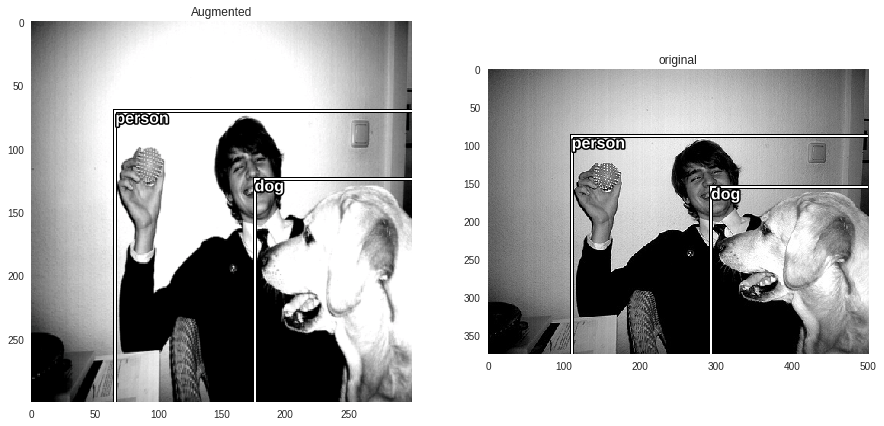

In [10]:
draw_im(trainset,64)

## Utility Function 

### Cordinate conversion (Encoding-Decoding)

In [0]:

def xy_to_cxcy(xy):
    """
    Convert bounding boxes from boundary coordinates (x_min, y_min, x_max, y_max) to center-size coordinates (c_x, c_y, w, h).

    :param xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).

    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).

    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.

    In the model, we are predicting bounding box coordinates in this encoded form.

    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.

    They are decoded into center-size coordinates.

    This is the inverse of the function above.

    :param gcxgcy: encoded bounding boxes, i.e. output of the model, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding is defined, a tensor of size (n_priors, 4)
    :return: decoded bounding boxes in center-size form, a tensor of size (n_priors, 4)
    """

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h

### Jacard Overlap(IoU)

In [0]:

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

### Average Meter (Calculating running average)

In [0]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Save Checkpoint

In [0]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer, loss, best_loss, is_best):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    filename = Path("/gdrive/My Drive/SSD_weights/checkpoint_ssd300.pt")
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state,   Path("/gdrive/My Drive/SSD_weights/BEST_checkpoint_ssd300.pt"))

### Decimate

In [0]:
def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.

    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.

    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor

  
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

## Model Architecture

### VGG Base

In [0]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

### AuxiliaryConvolutions

In [0]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

    def forward(self, conv7_feats):
        """
        Forward propagation.

        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats,conv11_2_feats

### Prediction Convolution

In [0]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.

    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.

    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.

        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

## SSD 300

In [0]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()
        self.init_conv2d()
    def init_conv2d(self):
      """
      Initialize convolution parameters.

      Note that we only do this for the auxiliary and prediction convolutions. The VGG base is a pre-trained model.
      """
      for c in self.aux_convs.children():
          if isinstance(c, nn.Conv2d):
              nn.init.constant_(c.bias, 0.)
      for c in self.pred_convs.children():
          if isinstance(c, nn.Conv2d):
              nn.init.constant_(c.bias, 0.)
              
    def load_pretrained_base(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of VGG base
        base_state_dict = self.base.state_dict()
        base_param_names = list(base_state_dict.keys())

        # Pretrained VGG base
        pretrained_base_state_dict = models.vgg16(pretrained=True).state_dict()
        pretrained_base_param_names = list(pretrained_base_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(base_param_names[:-4]):  # excluding conv6 and conv7 parameters
            base_state_dict[param] = pretrained_base_state_dict[pretrained_base_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_base_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_base_state_dict['classifier.0.bias']  # (4096)
        base_state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        base_state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_base_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_base_state_dict['classifier.3.bias']  # (4096)
        base_state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        base_state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.base.load_state_dict(base_state_dict)
        
        for layers in [*self.base.modules()][1:6]:
          for param in layers.parameters():
            param.requires_grad_(False)              
        print("Freeze first 4 layers")

        print("\nLoaded base model.\n")
    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats =self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.

        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

## MultiBox Loss Function

In [0]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.

    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction="none")

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

## Training

### Learning Parameters

In [0]:
batch_size=16
checkpoint = Path("/gdrive/My Drive/SSD_weights/BEST_checkpoint_ssd300.pt")
n_classes = len(trainset.class_names)  # number of different types of objects
start_epoch = 0  # start at this epoch
epochs = 50  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader
lr = 1e-3  # learning rate
weight_decay = 5e-4  # weight decay

### DataLoader

In [0]:
def collate_fn( batch):
  """
  Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

  This describes how to combine these tensors of different sizes. We use lists.

  Note: this need not be defined in this Class, can be standalone.

  :param batch: an iterable of N sets from __getitem__()
  :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels
  """
  images = list()
  boxes = list()
  labels = list()
  
  for b in batch:
      images.append(b[0])
      boxes.append(b[1])
      labels.append(b[2])

  images = torch.stack(images, dim=0)
  return images, boxes, labels  # tensor (N, ...), 3 lists of N tensors each

loader_param = { "batch_size":batch_size,
                 "pin_memory":True,
                 "num_workers":workers,
                 "collate_fn":collate_fn}

trainLoader = DataLoader(trainset,**loader_param,shuffle=True)

valsampler = torch.utils.data.RandomSampler(valset, replacement=True, num_samples=1000)
valLoader = DataLoader(valset  ,**loader_param ,shuffle=False, sampler=valsampler)

### Train method

In [0]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()
        
        #clip_gradient(optimizer, 0.5)        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
    print(' Epoch: [{0}]\t'
          'TRAIN  Loss {loss.avg:.4f}\t'.format(epoch, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    return losses.avg

### Validate method

In [0]:
def validate(val_loader, model, criterion):
    """
    One epoch's validation.

    :param val_loader: DataLoader for validation data
    :param model: model
    :param criterion: MultiBox loss
    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels) in enumerate(val_loader):

            # Move to default device
            images = images.to(device)  # (N, 3, 300, 300)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            # Forward prop.
            predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

            # Loss
            loss = criterion(predicted_locs, predicted_scores, boxes, labels)

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

    print('\n * VAL LOSS - {loss.avg:.3f}\n'.format(loss=losses))

    return losses.avg


### Actual training

In [0]:
def main(epochs):
  """
  
  Training and validation.
  """
  global epochs_since_improvement, start_epoch, best_loss, checkpoint
  model = SSD300(n_classes=n_classes).to(device)
  # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
  biases = list()
  not_biases = list()
  for param_name, param in model.named_parameters():
      if param.requires_grad:
          if param_name.endswith('.bias'):
              biases.append(param)
          else:
              not_biases.append(param)
  optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                 lr=lr, 
                 weight_decay=weight_decay)
  del biases ,not_biases 
  # Initialize model or load checkpoint
  if not checkpoint.exists():
      model.load_pretrained_base()

  else:
      checkpoint_dict = torch.load(checkpoint)
      start_epoch = checkpoint_dict['epoch'] + 1
      epochs_since_improvement = checkpoint_dict['epochs_since_improvement']
      best_loss = checkpoint_dict['best_loss']
      print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
      model.load_state_dict(checkpoint_dict['model'])
      optimizer.load_state_dict(checkpoint_dict['optimizer']) 

  criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

  # Epochs
  for epoch in trange(start_epoch,start_epoch+epochs):
      # Paper describes decaying the learning rate at the 80000th, 100000th, 120000th 'iteration', i.e. model update or batch
      # The paper uses a batch size of 32 (regardless of what we use), which means there are about 517 batches in an epoch
      # if epoch in {80000 // 517, 100000 // 517, 120000 // 517}:
      #     adjust_learning_rate(optimizer, 0.1)
      # In practice, I just decayed the learning rate when loss stopped improving for long periods,
      # and I would resume from the last best checkpoint with the new learning rate,
      # since there's no point in resuming at the most recent and significantly worse checkpoint.
      # So, just do adjust_learning_rate(optimizer, 0.1) when you're ready

      # One epoch's training
      train_loss = train(train_loader=trainLoader,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            epoch=epoch)

      # One epoch's validation
      val_loss = validate(val_loader=valLoader,
                          model=model,
                          criterion=criterion)

      # Did validation loss improve?
      is_best = val_loss < best_loss
      best_loss = min(val_loss, best_loss)

      if not is_best:
          epochs_since_improvement += 1
          print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

      else:
          epochs_since_improvement = 0

      # Save checkpoint
      save_checkpoint(epoch, epochs_since_improvement, model, optimizer, train_loss, best_loss, is_best)
  return model

In [0]:
model = main(epochs=epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Freeze first 4 layers

Loaded base model.

 Epoch: [0]	TRAIN  Loss 13.3880	

 * VAL LOSS - 13.137



  2%|▏         | 1/50 [09:26<7:42:59, 566.94s/it]

## Detection

In [0]:
def detect_objects( predicted_locs, predicted_scores, priors_cxcy,min_score=0.2, max_overlap=0.5, top_k=200):
  """
  Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.

  For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.

  :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
  :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
  :param min_score: minimum threshold for a box to be considered a match for a certain class
  :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
  :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
  :param prior_boxes the anchor box generated in the model
  :return: detections (boxes, labels, and scores), lists of length batch_size
  """
  batch_size = predicted_locs.shape[0]
  n_priors = priors_cxcy.shape[0]
  predicted_scores = F.softmax(predicted_scores , dim=2) # (N, 8732, n_classes)
  
  # Lists to store final predicted boxes, labels, and scores for all images
  all_images_boxes = list()
  all_images_labels = list()
  all_images_scores = list()
        
  assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)
  
  for i in range(batch_size):
    decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], priors_cxcy))  # (8732, 4), these are fractional pt. coordinates
    
    # Lists to store boxes and scores for this image
    image_boxes = list()
    image_labels = list()
    image_scores = list()
        
    # check for each classes
    for c in range(1 , n_classes):
      # Keep only predicted boxes and scores where scores for this class are above the minimum score
      class_scores = predicted_scores[i][:,c]
      score_above_min_score = class_scores > min_score
      
      n_above_min_score = score_above_min_score.sum().item()
      if n_above_min_score == 0:
        continue
      
      class_scores = class_scores[score_above_min_score]
      class_decoded_locs = decoded_locs[score_above_min_score]
      
      class_scores , sort_index = class_scores.sort(dim=0 , descending=True)
      class_decoded_locs = class_decoded_locs[sort_index]

      # Find the overlap between predicted boxes
      overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  

      # Non-Maximum Suppression (NMS)

      # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
      # 1 implies suppress, 0 implies don't suppress
      
      suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)
      
      for box in range(class_decoded_locs.size(0)):
        if suppress[box] ==1:
          continue
        
        # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
        # Find such boxes and update suppress indices
        suppress = torch.max(suppress, overlap[box] > max_overlap)
        # The max operation retains previously suppressed boxes, like an 'OR' operation

        # Don't suppress this box, even though it has an overlap of 1 with itself
        suppress[box] = 0
        
      # Store only unsuppressed boxes for this class
      image_boxes.append(class_decoded_locs[1 - suppress])
      image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
      image_scores.append(class_scores[1 - suppress])
      
     # If no object in any class is found, store a placeholder for 'background'
    if len(image_boxes) == 0:
        image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
        image_labels.append(torch.LongTensor([0]).to(device))
        image_scores.append(torch.FloatTensor([0.]).to(device))

    # Concatenate into single tensors
    image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
    image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
    image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
    n_objects = image_scores.size(0)

    # Keep only the top k objects
    if n_objects > top_k:
        image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
        image_scores = image_scores[:top_k]  # (top_k)
        image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
        image_labels = image_labels[sort_ind][:top_k]  # (top_k)

    # Append to lists that store predicted boxes and scores for all images
    all_images_boxes.append(image_boxes)
    all_images_labels.append(image_labels)
    all_images_scores.append(image_scores)
    
  return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

      

In [0]:
!wget https://i.pinimg.com/736x/4c/9e/2c/4c9e2c072ca71f045d6d7b0cb7398e02.jpg -O image.jpg
image = Image.open("image.jpg")
new_image = FT.resize(image,(300, 300))

# Convert PIL image to Torch tensor
new_image = FT.to_tensor(new_image)

# Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
new_image = FT.normalize(new_image, mean=trainLoader.dataset.mean, std=trainLoader.dataset.std)
new_image = new_image.unsqueeze(0)
new_image = new_image.to(device)
predicted_locs , predicted_scores = model(new_image)
det_boxes, det_labels, det_scores = detect_objects(predicted_locs, predicted_scores ,  priors_cxcy = model.priors_cxcy,min_score=0.3)
i , b , l ,s = new_image, det_boxes[0].to("cpu"), det_labels[0].to("cpu"), det_scores[0].to("cpu")
i = i.clone().detach().to("cpu").data
if len(i.shape)==4 : i = i.squeeze(0)
i = i.permute(1,2,0) 
i = i.mul_(trainLoader.dataset.std).add_(trainLoader.dataset.mean)
i = torch.clamp(i,0,1)
f, ax1 = plt.subplots(1, 1,figsize=(15,10))   
ax1.imshow(i)
ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])

for box ,label,score in zip(b , l,s):
  box = box * torch.FloatTensor([300]*4)
  draw_rect(ax1,box )
  draw_text(ax1, box[:2], trainLoader.dataset.class_names[label]+" "+str(score.item()), sz=16)

In [0]:
f.savefig("Objectdetect.jpg")

In [0]:
!cp Objectdetect.jpg /gdrive/My\ Drive/